# FISH integrated analyses

In [1]:
# Importing libraries
from sys import platform
import sys
# To import files from directories
import os; from os import listdir; from os.path import isfile, join
# Image reader
from skimage import io ; from skimage.io import imread
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
import matplotlib.path as mpltPath
# To manipulate arrays
import numpy as np 
import random
import re
import math
from tqdm.notebook import tqdm
import scipy
import pandas as pd
import pathlib
# Figure style and size
from matplotlib import gridspec
import warnings
warnings.filterwarnings("ignore")

In [2]:
import bigfish
import bigfish.stack as stack
import bigfish.segmentation as segmentation
import bigfish.plot as plot
import bigfish.detection as detection

In [3]:
# Deffining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')
#data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('MS2-Cy3')
data_dir = current_dir.parents[0].joinpath('dataBases').joinpath('GAPDH_Exon_Cy5')


In [4]:
# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

2021-10-26 09:38:17,302 [INFO] WRITING LOG OUTPUT TO /home/luisub/.cellpose/run.log


In [5]:
_, path_files, _, _ = fa.ReadImages(data_dir).read()

In [6]:
# Reading data from local memory
#list_file_names, list_merged_images, number_images, output_to_path = fa.MergeChannels(data_dir, substring_to_detect_in_file_name = '.*_C0.tif', save_figure =0).merge()

In [7]:
list_images, path_files, list_files_names, number_images = fa.ReadImages(data_dir).read()
#temp_img = stack.read_image(path_files[0])                                 # reading the image

2021-10-26 09:39:33,695 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:39:33,696 [INFO] >>>> using GPU
2021-10-26 09:39:33,838 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:39:33,839 [INFO] >>>> using GPU
2021-10-26 09:39:33,889 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:39:34,313 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-26 09:39:34,319 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:39:34,746 [INFO] >>>> TOTAL TIME 0.43 sec
2021-10-26 09:39:34,751 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:39:35,174 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-26 09:39:35,180 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:39:35,594 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:39:35,599 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:39:36,008 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:39:36,013 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:39:36,437 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-26 09:39:36,439 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:39:

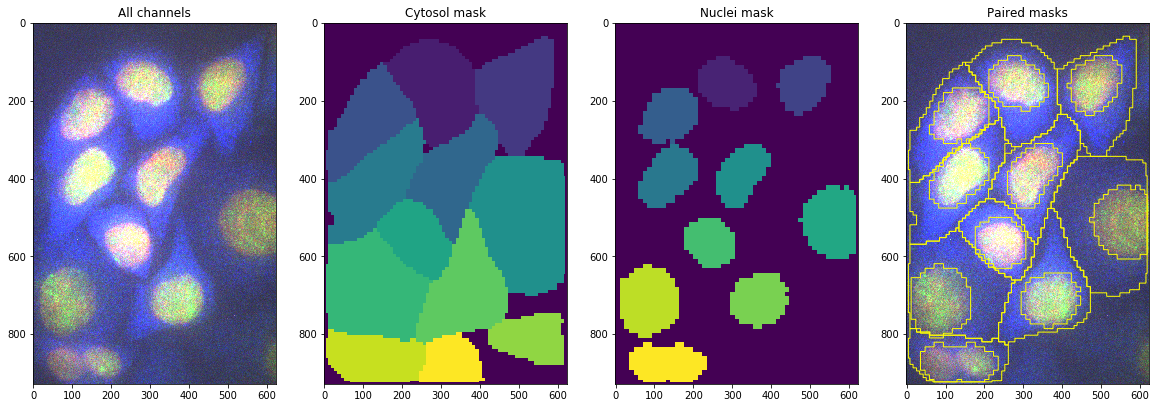

2021-10-26 09:40:07,522 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:40:07,523 [INFO] >>>> using GPU
2021-10-26 09:40:07,667 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:40:07,668 [INFO] >>>> using GPU
2021-10-26 09:40:07,717 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:08,145 [INFO] >>>> TOTAL TIME 0.43 sec
2021-10-26 09:40:08,150 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:08,565 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:08,570 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:08,977 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:08,982 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:09,388 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:09,392 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:09,796 [INFO] >>>> TOTAL TIME 0.40 sec
2021-10-26 09:40:09,800 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:10,212 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:10,214 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:40:

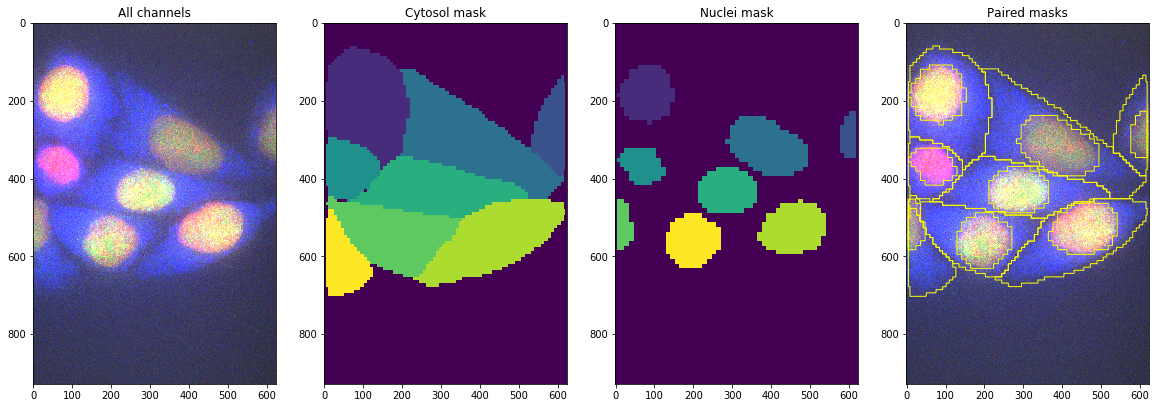

2021-10-26 09:40:38,648 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:40:38,648 [INFO] >>>> using GPU
2021-10-26 09:40:38,780 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:40:38,781 [INFO] >>>> using GPU
2021-10-26 09:40:38,830 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:39,269 [INFO] >>>> TOTAL TIME 0.44 sec
2021-10-26 09:40:39,275 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:39,721 [INFO] >>>> TOTAL TIME 0.45 sec
2021-10-26 09:40:39,726 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:40,136 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:40,141 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:40,550 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:40,555 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:40,960 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:40:40,965 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:40:41,391 [INFO] >>>> TOTAL TIME 0.43 sec
2021-10-26 09:40:41,393 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:40:

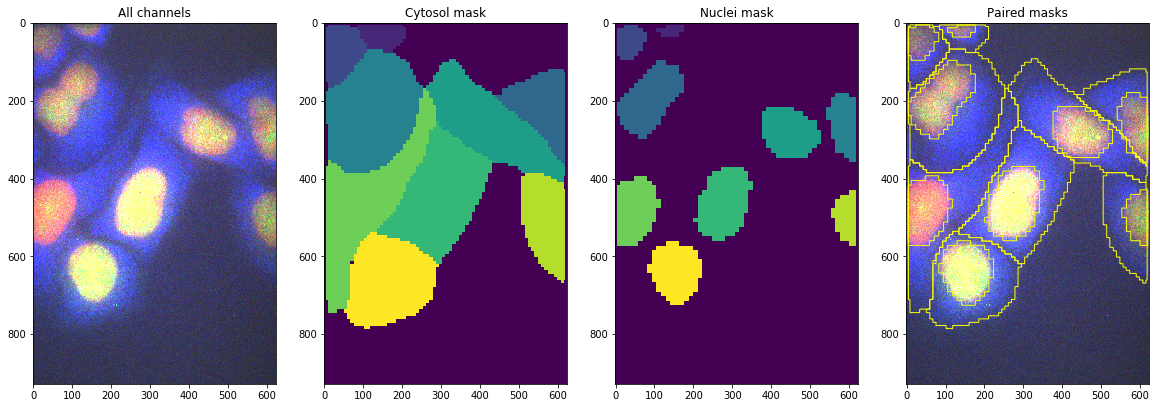

2021-10-26 09:41:10,723 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:41:10,724 [INFO] >>>> using GPU
2021-10-26 09:41:10,856 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:41:10,857 [INFO] >>>> using GPU
2021-10-26 09:41:10,907 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:11,361 [INFO] >>>> TOTAL TIME 0.45 sec
2021-10-26 09:41:11,367 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:11,828 [INFO] >>>> TOTAL TIME 0.46 sec
2021-10-26 09:41:11,835 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:12,287 [INFO] >>>> TOTAL TIME 0.45 sec
2021-10-26 09:41:12,293 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:12,740 [INFO] >>>> TOTAL TIME 0.45 sec
2021-10-26 09:41:12,746 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:13,190 [INFO] >>>> TOTAL TIME 0.44 sec
2021-10-26 09:41:13,196 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:13,654 [INFO] >>>> TOTAL TIME 0.46 sec
2021-10-26 09:41:13,656 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:41:

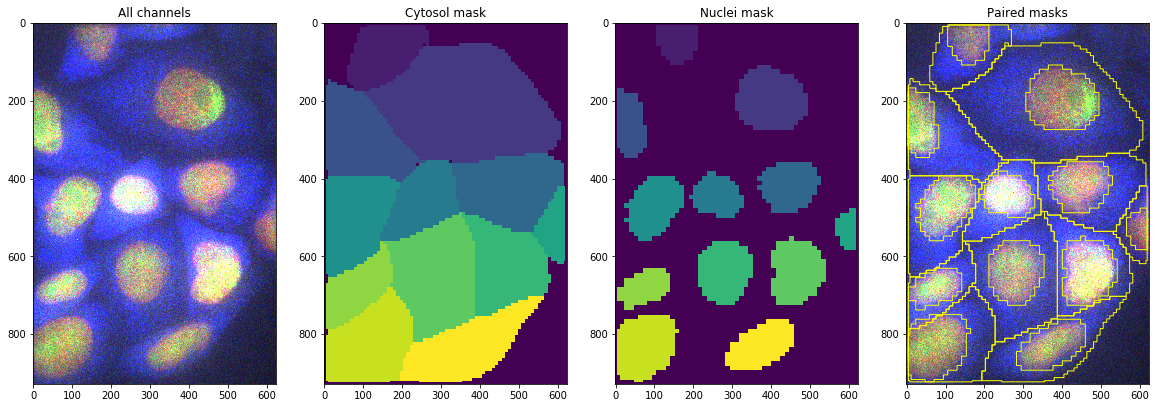

2021-10-26 09:41:47,302 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:41:47,302 [INFO] >>>> using GPU
2021-10-26 09:41:47,436 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:41:47,437 [INFO] >>>> using GPU
2021-10-26 09:41:47,486 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:47,945 [INFO] >>>> TOTAL TIME 0.46 sec
2021-10-26 09:41:47,951 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:48,405 [INFO] >>>> TOTAL TIME 0.45 sec
2021-10-26 09:41:48,411 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:48,886 [INFO] >>>> TOTAL TIME 0.48 sec
2021-10-26 09:41:48,892 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:49,312 [INFO] >>>> TOTAL TIME 0.42 sec
2021-10-26 09:41:49,318 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:49,731 [INFO] >>>> TOTAL TIME 0.41 sec
2021-10-26 09:41:49,736 [INFO] ~~~ FINDING MASKS ~~~
2021-10-26 09:41:50,162 [INFO] >>>> TOTAL TIME 0.43 sec
2021-10-26 09:41:50,164 [INFO] ** TORCH CUDA version installed and working. **
2021-10-26 09:41:

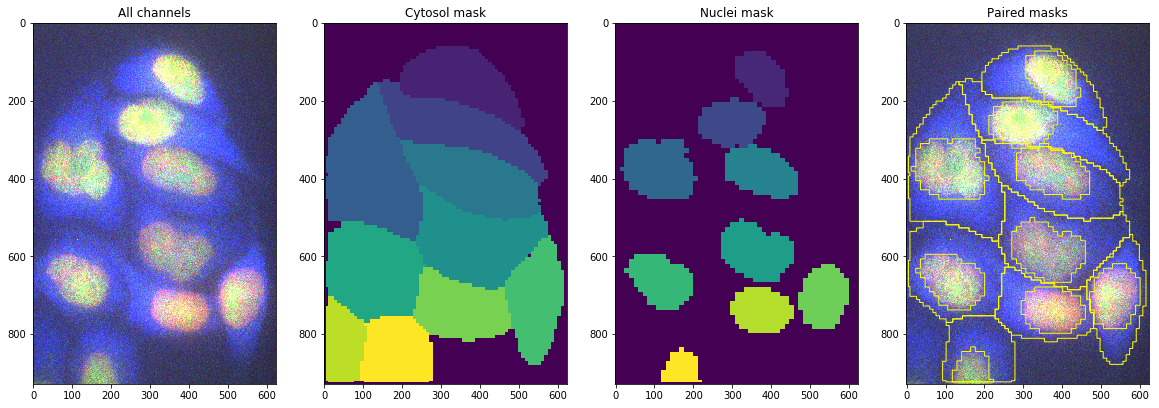

In [12]:
remove_fragmented_cells = False
for i in range(0,5):
    masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, index_paired_masks = fa.CellposeFISH(list_images[i],channel_with_cytosol=[1,2], channel_with_nucleus=0,diameter_cytosol =250, diamter_nucleus=200,remove_fragmented_cells= remove_fragmented_cells, show_plot=1).calculate_masks()  # Detect only nucleus

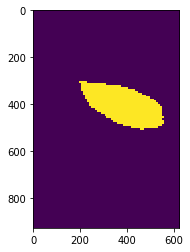

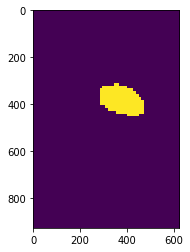

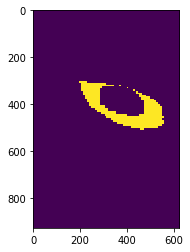

In [16]:
mask_num = 3
plt.imshow(masks_complete_cells[mask_num])
plt.show()
plt.imshow(masks_nuclei[mask_num])
plt.show()
plt.imshow(masks_cytosol_no_nuclei[mask_num])
plt.show()

In [ ]:
class DataProcessing():
    '''
    This class is intended to extract data from the class SpotDetection and return the data as a dataframe. 
    
    Parameters
    --  --  --  --  -- 

    spotDectionCSV: np.int64 Array with shape (nb_clusters, 5) or (nb_clusters, 4). 
            One coordinate per dimension for the clusters centroid (zyx or yx coordinates), the number of spots detected in the clusters and its index.
    clusterDectionCSV : np.int64 with shape (nb_spots, 4) or (nb_spots, 3).
            Coordinates of the detected spots . One coordinate per dimension (zyx or yx coordinates) plus the index of the cluster assigned to the spot. If no cluster was assigned, value is -1.
    masks_complete_cells : List of NumPy arrays or a single NumPy array
            Masks for every cell detected in the image. The list contains the mask arrays consisting of one or multiple Numpy arrays with format [Y, X].
    masks_nuclei: List of NumPy arrays or a single NumPy array
            Masks for every cell detected in the image. The list contains the mask arrays consisting of one or multiple Numpy arrays with format [Y, X].
    masks_cytosol_no_nuclei : List of NumPy arrays or a single NumPy array
            Masks for every cell detected in the image. The list contains the mask arrays consisting of one or multiple Numpy arrays with format [Y, X].
    counter_total_cells : int, optional
        index to indicate the number of cells on the dataframe. The default is 0.
    dataframe : Pandas dataframe or None.
        Pandas dataframe with the following columns. image_id, cell_id, spot_id, nucleus_y, nucleus_x, nuc_area_px, cyto_area_px, cell_area_px, z, y, x, is_nuc, is_cluster, cluster_size. The default is None.
    '''
    def __init__(self,spotDectionCSV, clusterDectionCSV,masks_complete_cells, masks_nuclei, masks_cytosol_no_nuclei, counter_total_cells=0,dataframe =None):
        self.spotDectionCSV=spotDectionCSV 
        self.clusterDectionCSV=clusterDectionCSV
        self.masks_complete_cells=masks_complete_cells
        self.masks_nuclei=masks_nuclei
        self.masks_cytosol_no_nuclei=masks_cytosol_no_nuclei
        self.counter_total_cells=counter_total_cells
        self.dataframe =dataframe


    def get_dataframe(self):
        '''
        This method extracts data from the class SpotDetection and return the data as a dataframe.

        Returns
        --  --  -- -
        dataframe,  : Pandas dataframe
            Pandas dataframe with the following columns. image_id, cell_id, spot_id, nucleus_y, nucleus_x, nuc_area_px, cyto_area_px, cell_area_px, z, y, x, is_nuc, is_cluster, cluster_size.
        counter_total_cells : int
            Index indicating the number of cells in the current dataframe.
        '''
    
        def mask_selector(masks, id,calculate_centroid= True):
            temp_mask = np.zeros_like(masks) # making a copy of the image
            selected_mask = temp_mask + (masks==id) # Selecting a single mask and making this mask equal to one and the background equal to zero.
            mask_area = np.count_nonzero(selected_mask)
            if calculate_centroid == True:
                centroid_y,centroid_x = ndimage.measurements.center_of_mass(selected_mask)
            else:
                centroid_y,centroid_x = 0,0
            return selected_mask , mask_area, centroid_y,centroid_x


        def data_to_df( df, spotDectionCSV, clusterDectionCSV, mask_nuc = None, mask_cytosol_only=None, nuc_area = 0, cyto_area =0, cell_area=0, centroid_y=0, centroid_x=0, image_counter=0, cell_counter =0 ):
            # spotDectionCSV      nrna x  [Z,Y,X,idx_foci]
            # clusterDectionCSV   nc   x  [Z,Y,X,size,idx_foci]

            # Removing TS from the image and calculating RNA in nucleus
            spots_no_ts, _, ts = stack.remove_transcription_site(spotDectionCSV, clusterDectionCSV, mask_nuc, ndim=3)
            #rna_out_ts      [Z,Y,X,idx_foci]         Coordinates of the detected RNAs with shape. One coordinate per dimension (zyx or yx coordinates) plus the index of the foci assigned to the RNA. If no foci was assigned, value is -1. RNAs from transcription sites are removed.
            #foci            [Z,Y,X,size, idx_foci]   One coordinate per dimension for the foci centroid (zyx or yx coordinates), the number of RNAs detected in the foci and its index.
            #ts              [Z,Y,X,size,idx_ts]      One coordinate per dimension for the transcription site centroid (zyx or yx coordinates), the number of RNAs detected in the transcription site and its index.
            spots_nuc, _ = stack.identify_objects_in_region(mask_nuc, spots_no_ts, ndim=3)

            # Detecting spots in the nucleus
            spots_cytosol_only, _ = stack.identify_objects_in_region(mask_cytosol_only, spotDectionCSV[:,:3], ndim=3)
            # coord_innp  Coordinates of the objects detected inside the region.
            # coord_outnp Coordinates of the objects detected outside the region.

            # ts                     n x [Z,Y,X,size,idx_ts]
            # spots_nuc              n x [Z,Y,X]
            # spots_cytosol_only     n x [Z,Y,X]

            number_columns = len(df. columns)
            num_ts = ts.shape[0]
            num_nuc = spots_nuc.shape[0]
            num_cyt = spots_cytosol_only.shape[0] 

            array_ts =                  np.zeros( ( num_ts,number_columns)  )
            array_spots_nuc =           np.zeros( ( num_nuc,number_columns) )
            array_spots_cytosol_only =  np.zeros( ( num_cyt  ,number_columns) )

            # Spot index 
            spot_idx_ts =  np.arange(0,                  num_ts                                                 ,1 )
            spot_idx_nuc = np.arange(num_ts,             num_ts + num_nuc                                       ,1 )
            spot_idx_cyt = np.arange(num_ts + num_nuc,   num_ts + num_nuc + num_cyt  ,1 )
            spot_idx = np.concatenate((spot_idx_ts,  spot_idx_nuc, spot_idx_cyt ))

            # Populating arrays
            array_ts[:,8:11] = ts[:,:3] # populating coord 
            array_ts[:,11] = 1          # is_nuc
            array_ts[:,12] = 1          # is_cluster
            array_ts[:,13] =  ts[:,3]   # cluster_size

            array_spots_nuc[:,8:11] = spots_nuc[:,:3] # populating coord 
            array_spots_nuc[:,11] = 1                 # is_nuc
            array_spots_nuc[:,12] = 0                 # is_cluster
            array_spots_nuc[:,13] = 0                 # cluster_size

            array_spots_cytosol_only[:,8:11] = spots_cytosol_only[:,:3] # populating coord 
            array_spots_cytosol_only[:,11] = 0                 # is_nuc
            array_spots_cytosol_only[:,12] = 0                 # is_cluster
            array_spots_cytosol_only[:,13] =  0                # cluster_size

            # concatenate array
            array_complete = np.vstack((array_ts, array_spots_nuc, array_spots_cytosol_only))
            
            # Saves a dataframe with zeros when no spots  are detected on the cell.
            if array_complete.size ==0:
                array_complete = np.zeros( ( 1,number_columns)  )
                # if NO spots are detected populate  with -1
                array_complete[:,2] = -1     # spot_id
                array_complete[:,8:11] = -1
            else:
                # if spots are detected populate  the reported  array
                array_complete[:,2] = spot_idx.T     # spot_id
            # populating  array with cell  information
            array_complete[:,0] = image_counter  # image_id
            array_complete[:,1] = cell_counter   # cell_id
            array_complete[:,3] = centroid_y     #'nuc_y_centoid'
            array_complete[:,4] = centroid_x     #'nuc_x_centoid'
            array_complete[:,5] = nuc_area       #'nuc_area_px'
            array_complete[:,6] = cyto_area      # cyto_area_px
            array_complete[:,7] = cell_area      #'cell_area_px'

            # df = pd.DataFrame( columns=['image_id', 'cell_id', 'spot_id','nucleus_y', 'nucleus_x','nuc_area_px','cyto_area_px', 'cell_area_px','z', 'y', 'x','is_nuc','is_cluster','cluster_size'])
            df = df.append(pd.DataFrame(array_complete, columns=df.columns), ignore_index=True)
            return df


        # Initializing Dataframe
        if not ( dataframe is None):
            dataframe = pd.DataFrame( columns=['image_id', 'cell_id', 'spot_id','nucleus_y', 'nucleus_x','nuc_area_px','cyto_area_px', 'cell_area_px','z', 'y', 'x','is_nuc','is_cluster','cluster_size'])
        self.dataframe = dataframe 

        # loop for each cell in image
        n_masks = np.amax(self.masks_nuclei)
        for id_cell in range (1,n_masks+1): # iterating for each mask in a given cell. The mask has values from 0 for background, to int n, where n is the number of detected masks.
            selected_nuc_mask , nuc_area, nuc_centroid_y, nuc_centroid_x      = mask_selector(self.masks_nuclei, id_cell)
            selected_cyt_only_mask , cyto_area, _ ,_                          = mask_selector(self.masks_cytosol_no_nuclei, id_cell,calculate_centroid=False)
            selected_cell_mask , cell_area, _, _                              = mask_selector(self.masks_complete_cells, id_cell,calculate_centroid=False)
            # Data extraction
            dataframe = data_to_df(self.dataframe, 
                                self.spotDectionCSV, 
                                self.clusterDectionCSV, 
                                mask_nuc = self.selected_nuc_mask, 
                                mask_cytosol_only=self.selected_cyt_only_mask, 
                                nuc_area=nuc_area,
                                cyto_area=cyto_area, 
                                cell_area=cell_area, 
                                centroid_y = nuc_centroid_y, 
                                centroid_x = nuc_centroid_x,
                                image_counter=i,
                                cell_counter =counter_total_cells)
            counter_total_cells +=1
        return dataframe, counter_total_cells

In [10]:
raise

RuntimeError: No active exception to reraise

In [ ]:
def plot_original_images(image, figsize=(8.5, 5)):
  '''
  This function plots all the channels for the original image.
  '''
  #print(' \n ####### ---ORIGINAL IMAGE--- ####### \n')
  number_channels = image.shape[3]
  fig, axes = plt.subplots(nrows=1, ncols=number_channels, figsize=figsize)
  for i in range (0,number_channels ):
    img_2D = stack.focus_projection(image[:,:,:,i], proportion=0.7, neighborhood_size=7, method='max') # maximum projection 
    img_2D = stack.gaussian_filter(img_2D,sigma=5)
    axes[i].imshow( img_2D ,cmap='viridis') 
    axes[i].set_title('Channel_'+str(i))
  plt.show()

In [ ]:
def image_extraction(image_or_path, nucleus_channel= None, cell_channel=None, FISH_channel_experiment_0=None, FISH_channel_experiment_1=None,show_plot=False):
  '''
  This function is inteded to extract all information from the file path and return 2D, maximum projections, and 3D images for the nucleus, cell, and RNA channels.
  '''
  if type(image_or_path) ==np.ndarray:
    image = image_or_path                                              # loading the image
  else:
    image = stack.read_image(image_or_path)                            # reading the image
    print('not reading')
  sliceNum = image.shape[0]//2                                         # selecting the slice in the medium of the stack
  def image_extraction_function(img,sliceNum,selected_channel=None):
    if not ( selected_channel is None):
      img_3D = img[:,:,:,selected_channel]                               # 3D image 
      img_2D = stack.focus_projection(img[:,:,:,selected_channel], proportion=0.7, neighborhood_size=7, method='max') # maximum projection 
      img_2D = stack.gaussian_filter(img_2D,sigma=5)
    else:
      img_3D,img_2D = None, None
    return img_3D,img_2D
  nuc_3D,nuc_2D = image_extraction_function(image,sliceNum,selected_channel=nucleus_channel)
  cell_3D,cell_2D = image_extraction_function(image,sliceNum,selected_channel=cell_channel)
  fish_0_3D, fish_0_2D = image_extraction_function(image,sliceNum,selected_channel=FISH_channel_experiment_0)
  fish_1_3D, fish_1_2D = image_extraction_function(image,sliceNum,selected_channel=FISH_channel_experiment_1)
  ## Plotting
  if show_plot == True:
    plot_original_images(image, figsize=(8.5, 5))
  return nuc_3D, nuc_2D, cell_3D, cell_2D, fish_0_3D, fish_0_2D, fish_1_3D, fish_1_2D

In [ ]:
nucleus_channel = 0 
cell_channel = 1
FISH_channel_experiment_0 = 2 
FISH_channel_experiment_1 = None
nuc_3D, nuc_2D, cell_3D, cell_2D, fish_0_3D, fish_0_2D, fish_1_3D, fish_1_2D = image_extraction(list_images[0], nucleus_channel, cell_channel, FISH_channel_experiment_0, FISH_channel_experiment_1,show_plot=True)

In [ ]:
def remove_fragmented(img_masks):
    img_masks_copy = np.copy(img_masks)
    for nm in range(1,np.amax(img_masks)+1):
        tested = np.where(img_masks_copy == nm, 1, 0)   # making zeros all elements outside each mask, and once all elements inside of each mask.
        # testing if tested is touching the border of the image
        is_border = np.any( np.concatenate( ( tested[:,0],tested[:,-1],tested[0,:],tested[-1,:] ) ) )
        if is_border == True:
            img_masks = np.where(img_masks == nm, 0, img_masks)
    return img_masks

In [ ]:
def nucleus_segmentation(nuc_img_2D,use_unet_nuc=True, thresholdLabel_nuc=None,small_object_size_nuc=5000,remove_fragmented_masks=True):
    is_border = lambda img: np.any( np.concatenate( ( img[:,0],img[:,-1],img[0,:],img[-1,:] ) ) )
    if use_unet_nuc == True: # segmentation using U-net
        model_nuc = segmentation.unet_3_classes_nuc() # load pretrained model
        nuc_label = segmentation.apply_unet_3_classes(model_nuc, nuc_img_2D, target_size=256, test_time_augmentation=True) # instance segmentation
    else: # Cell segmentation using watershed
        nuc_label = segmentation.thresholding(nuc_img_2D, threshold=thresholdLabel_nuc)
    #Cleaning results
    if remove_fragmented_masks==True:
        nuc_label = remove_fragmented(nuc_label)
    nuc_label = segmentation.clean_segmentation(nuc_label,  smoothness=10, small_object_size=small_object_size_nuc, delimit_instance=True,fill_holes=True)
    nuc_label= segmentation.remove_disjoint(nuc_label)
    return nuc_label

In [ ]:
def cytosol_segmentation(cell_img_2D,nuc_label,nuc_img_2D=None,use_unet_cell=False, thresholdLabel_cell=None,small_object_size_cell=10000,remove_fragmented_masks=True):
    if use_unet_cell == True: # segmentation using U-net 
        model_cell = segmentation.unet_distance_edge_double() 
        cell_label = segmentation.apply_unet_distance_double(model_cell, nuc=nuc_img_2D, cell=cell_img_2D, nuc_label=nuc_label, target_size=256, test_time_augmentation=True) # instance segmentation
    else: # Cell segmentation using watershed
        cell_label = segmentation.cell_watershed(cell_img_2D, nuc_label, threshold=thresholdLabel_cell, alpha=0.8)
        
    if remove_fragmented_masks==True:
        cell_label = remove_fragmented(cell_label)
    cell_label = segmentation.clean_segmentation(cell_label, smoothness=10, small_object_size=small_object_size_cell, delimit_instance=True,fill_holes=True)
    cell_label= segmentation.remove_disjoint(cell_label)
    return cell_label

In [ ]:
def match_nuc_and_cell(nuc_label, cell_label):
    # mathcing nuc and cell labels
    segmentationNucLabel, segmentationCellLabel = segmentation.match_nuc_cell(nuc_label, cell_label, single_nuc=False, cell_alone=False)
    # Creating cytosol_only_mask
    if np.amax(segmentationNucLabel) ==0:
        #print('No marches between nucleus and cytosol masks')
        segmentationNucLabel, segmentationCellLabel,segmentation_cytosol_only = nuc_label, cell_label, np.zeros_like(segmentationNucLabel)
    else:
        segmentation_cytosol_only = np.zeros_like(segmentationNucLabel)
        for nm in range(1,np.amax(segmentationNucLabel)+1):
            nuc_copy = segmentationNucLabel.copy()
            cell_copy = segmentationCellLabel.copy()
            tested_nuc_mask = np.where(nuc_copy == nm, -1, 0)    # making zeros all elements outside each mask, and -1 all elements inside of each mask.
            tested_cell_mask = np.where(cell_copy == nm, 1, 0)   # making zeros all elements outside each mask, and once all elements inside of each mask.
            merged = tested_nuc_mask + tested_cell_mask          # substracting nuc from cytosol
            merged = np.where(merged == 1, nm, 0)
            segmentation_cytosol_only = segmentation_cytosol_only + merged             # populating cytosol_only_mask with int that match the order in segmentationNucLabel and segmentationCellLabel
    return segmentationNucLabel, segmentationCellLabel, segmentation_cytosol_only

In [ ]:
def cytosol_objective_function(cell_img_2D,nuc_label,nuc_img_2D=None, thresholdLabel_cell =495,remove_fragmented_cells=True ,small_object_size_cell=10000):
    # segments images, only one image at a time is passed through function 
    counter_total_cells = 0
    number_detected_cells = []
    # Cell segmentation
    cell_label = cytosol_segmentation(cell_img_2D,nuc_label,nuc_img_2D=nuc_img_2D,use_unet_cell=False, thresholdLabel_cell=thresholdLabel_cell,small_object_size_cell=small_object_size_cell,remove_fragmented_masks=remove_fragmented_cells)
    # Matching nucleus and cell
    segmentationNucLabel, segmentationCellLabel,segmentation_cytosol_only= match_nuc_and_cell(nuc_label, cell_label)
    masks_cytosol = segmentation_cytosol_only
    number_detected_cells = np.amax(segmentation_cytosol_only)
    if number_detected_cells ==0:
        masks_cytosol = np.zeros_like(segmentation_cytosol_only)
    # Objective Function calculation
    area_in_all_cells = np.count_nonzero(segmentationCellLabel)  # total cells area
    obj_return_vector = number_detected_cells * area_in_all_cells # objective function output = [Total area * number of cells]
    return obj_return_vector

In [ ]:
def mask_optimization_function(nuc_2D, cell_2D,thres_begin =400, thres_end = 600,num_ts=30,remove_fragmented_cells=True,show_plot=False):
  vector_thresholds = np.linspace(thres_begin,thres_end,num_ts) # Range of thresholds tested Spaces threshold values by 1
  obj_return_vector = np.zeros((len(vector_thresholds)))  # Preallocation for objective function output [Total area * number of cells]
  # Nucleus segmentation
  nuc_label = nucleus_segmentation(nuc_2D,use_unet_nuc=True, thresholdLabel_nuc=None,small_object_size_nuc=5000,remove_fragmented_masks=True)
  # code for cytosol optimization
  for i in range(len(vector_thresholds)):
    obj_return_vector[i]  = cytosol_objective_function(cell_2D,nuc_label,nuc_img_2D=nuc_2D, thresholdLabel_cell =vector_thresholds[i],remove_fragmented_cells=True ,small_object_size_cell=10000)
  obj_return_vector[obj_return_vector==0]=1
  obj_max_position = np.argmax(obj_return_vector) # Location of maximum value
  selected_threshold = vector_thresholds[obj_max_position] # threshold at max
  # Plotting
  if show_plot== True:
    plt.figure(figsize=(8, 5))
    plt.plot(vector_thresholds, obj_return_vector,linewidth=3,color='b')# Plots Objective Function
    plt.plot([selected_threshold,selected_threshold],[np.amin(obj_return_vector), np.amax(obj_return_vector)  ],linewidth=3,color='r')# Plots Objective Function
    plt.ylabel("Number of cells * area")
    plt.xlabel("Thresholds")
    plt.yscale("log")
    plt.show()
  # Returns the threshold that give the max and the max value
  return selected_threshold

In [ ]:
def segmentation_complete(nuc_2D, cell_2D,use_unet_nuc=True, use_unet_cell=False ,thresholdLabel_cell=500,small_object_size_nuc=5000,small_object_size_cell=10000,remove_fragmented_masks=True,show_plot=False):
    # Nucleus segmentation
    nuc_label = nucleus_segmentation(nuc_2D,use_unet_nuc=use_unet_nuc, thresholdLabel_nuc=None,small_object_size_nuc=small_object_size_nuc,remove_fragmented_masks=remove_fragmented_masks)
    # Cell segmentation
    cell_label = cytosol_segmentation(cell_2D,nuc_label,nuc_img_2D=nuc_2D,use_unet_cell=use_unet_cell, thresholdLabel_cell=thresholdLabel_cell,small_object_size_cell=small_object_size_cell,remove_fragmented_masks=remove_fragmented_masks)
    # Matching nucleus and cell
    segmentationNucLabel, segmentationCellLabel,segmentation_cytosol_only= match_nuc_and_cell(nuc_label, cell_label)
    # Plotting
    if show_plot== True:
        plot.plot_images([ segmentationNucLabel, segmentationCellLabel ,  segmentation_cytosol_only], titles=["Nucleus", "Cytosol","Cytosol_only" ], framesize=(8.5, 5))
        plt.show() 
    return segmentationNucLabel, segmentationCellLabel,segmentation_cytosol_only

In [ ]:
nucleus_channel = 0
cell_channel = 2
FISH_channel_experiment_0 = 2
num_tested_thresholds = 30         
remove_fragmented_cells = True 
show_plot = True
thres_begin = 400
thres_end = 1000
# Auto threshold selection
nuc_3D, nuc_2D, cell_3D, cell_2D, fish_0_3D, fish_0_2D, fish_1_3D, fish_1_2D = image_extraction(list_images[2], nucleus_channel, cell_channel, FISH_channel_experiment_0, FISH_channel_experiment_1,show_plot=show_plot)
selected_threshold = mask_optimization_function( nuc_2D, cell_2D,thres_begin =thres_begin, thres_end = thres_end,num_ts=num_tested_thresholds,remove_fragmented_cells=remove_fragmented_cells,show_plot=show_plot) 
segmentationNucLabel, segmentationCellLabel,segmentation_cytosol_only = segmentation_complete(nuc_2D, cell_2D, thresholdLabel_cell=selected_threshold,small_object_size_nuc=5000,small_object_size_cell=10000,remove_fragmented_masks=False,show_plot=True)

In [ ]:
raise

In [ ]:
import os; from os import listdir; from os.path import isfile, join
import re  
#from skimage import io 
from skimage.io import imread
# To manipulate arrays
import numpy as np 
import random
from tqdm.notebook import tqdm
from timeit import default_timer as timer
import scipy
import pandas as pd
import shutil
import pathlib
import sys
from skimage.exposure import rescale_intensity
import rsnapsim as rss
from skimage.measure import find_contours
# Plotting
import matplotlib as mpl ; import matplotlib.pyplot as plt 
# To create interactive elements
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout ; from IPython.display import Image

import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Parallel computing
from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

In [ ]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
#trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','bactin_ssa.npy')
trajectories_dir = current_dir.parents[1].joinpath('DataBases','rsnapsim_simulations','kdm5b_ssa.npy')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')
gene_file = current_dir.parents[1].joinpath('DataBases','gene_files','KDM5B_withTags.txt')

In [ ]:
# Paths to dropbox
from sys import platform as _platform
if _platform == "linux" or _platform == "linux2":
    dropbox_address = pathlib.Path('/','home','luisub','Dropbox', 'Project_rSNAPed','manuscript','Figures')
elif _platform == "darwin":
    dropbox_address = pathlib.Path('/','Users','luisaguilera','Dropbox', 'Project_rSNAPed','manuscript','Figures')

In [ ]:
# Importing rSNAPed
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False

In [ ]:
from dna_features_viewer import BiopythonTranslator
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#ff0000"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7": 
            return "#EB5559"
        else:
            return "#C4B07B"

In [ ]:
# Plasmid sequences
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('kdm5b.gb')) # plasmid pUB_SM_KDM5B_PP7 
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
#ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
name_figure = 'sequence.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
ax.figure.savefig(figure_directory)

In [ ]:
plt.style.use('ggplot')

In [ ]:
# These are the parameters that need to be tested. 
number_of_simulated_cells = 1 # PLEASE TEST MIN 1 MAX 10
number_spots_per_cell = 100     # PLEASE TEST MIN 5 MAX 200
diffusion_coefficient = 0.7    # PLEASE TEST MIN 0.1 MAX 2

In [ ]:
intensity_calculation_method = 'disk_donut'  # options are : 'total_intensity' and 'disk_donut' 'gaussian_fit'
mask_selection_method = 'max_area' # options are : 'max_spots' and 'max_area' 
use_optimization_for_tracking = 1 # 0 not using, 1 is using optimization
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'

In [ ]:
particle_size = 7 # spot size for the simulation and tracking.
elongation_rate = 10
initiation_rate = 0.03

In [ ]:
# Perturbations
use_Harringtonin = 0
use_FRAP =0

In [ ]:
if use_FRAP == 1:
    name_files = 'FRAP'
    simulation_time_in_sec = 301    
    perturbation_time_start = 100
    perturbation_time_stop = 105
    
if use_Harringtonin ==1:
    name_files = 'HT'
    simulation_time_in_sec = 801    
    perturbation_time_start = 400
    perturbation_time_stop = 0

if (use_FRAP ==0 ) and (use_Harringtonin==0):
    name_files = 'SIM_'
    simulation_time_in_sec = 801    
    perturbation_time_start = 0
    perturbation_time_stop = 0
    
if (use_FRAP ==1 ) and (use_Harringtonin==1):
    raise ValueError ('FRAP and HT can not be deffined at the same time')

In [ ]:
intensity_scale_ch0 = 100
intensity_scale_ch1 = 200
intensity_scale_ch2 = 200

In [ ]:
particle_detection_size = particle_size

## Running the simulations

In [ ]:
def fun_simulated_cells(current_dir, video_dir,ke=3,ki=0.03,gene_file =None, trajectories_dir=None, number_of_simulated_cells=3,number_spots_per_cell=80,
    simulation_time_in_sec =100,step_size_in_sec=1,particle_size=5, diffusion_coefficient =1,path_to_rSNAPsim= None, path_to_save_output='temp',
    intensity_calculation_method='gaussian_fit',frame_selection_empty_video=frame_selection_empty_video,
    perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP ):
    spot_size = particle_size
    spot_sigma = 1
    # Code that creates the folder to store results.
    diffusion_coefficient_string = str(diffusion_coefficient).replace('.','_')
    directory_name = 'Simulation_V2__'+'ns_'+str(number_spots_per_cell) +'_diff_'+ diffusion_coefficient_string 
    path_to_save_output = 'temp'
    save_to_path =  current_dir.joinpath(path_to_save_output , directory_name )
    if not os.path.exists(str(save_to_path)):
        os.makedirs(str(save_to_path))
    else:
        shutil.rmtree(str(save_to_path))
        os.makedirs(str(save_to_path))
    counter = 0
    ## Main loop that creates each cell and dataframe
    for cell_number in range (0, number_of_simulated_cells):
        output_directory_name = str(video_dir)
        list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
        list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
        path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
        selected_video = 7
        video_path = path_files[selected_video]        
        video = imread(video_path) 
        # Reducing in a half the intensity in the original video
        video = video//2
        empty_videos = video
        counter +=1
        if counter>=len(path_files):
            counter =0
        if not (trajectories_dir is None ):
            # Loading trajectories from file
            ssa_trajectories = np.load(str(trajectories_dir))
            random_index_ch0 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch1 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            random_index_ch2 = np.random.randint(low=0, high=ssa_trajectories.shape[0]-1, size=(number_spots_per_cell,))
            
            simulated_trajectories_ch0 = ssa_trajectories[random_index_ch0,0:simulation_time_in_sec:step_size_in_sec] / 10 # converting to ump
            simulated_trajectories_ch1 = ssa_trajectories[random_index_ch1,0:simulation_time_in_sec:step_size_in_sec] / 10 # converting to ump
            simulated_trajectories_ch2 =  ssa_trajectories[random_index_ch2,0:simulation_time_in_sec:step_size_in_sec] / 10 # converting to ump
        else:
            # Simulations for intensity
            ssa1,ssa1_ump,_ = rsp.SSA_rsnapsim(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP, perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop).simulate() # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch1 = ssa1_ump
            ssa2,ssa2_ump,_ =  rsp.SSA_rsnapsim(gene_file,ke,ki,frames=simulation_time_in_sec,frame_rate=1,n_traj=number_spots_per_cell,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP, perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop).simulate() # rss.ssa_solver(n_traj = number_spots_per_cell, start_time=starting_time,tf=starting_time+n_frames, tstep=starting_time+n_frames,k_elong_mean=3, k_initiation=.03)  # tstep = total number of steps including the burnin time 
            simulated_trajectories_ch2 = ssa2_ump
            simulated_trajectories_ch0 = simulated_trajectories_ch1
        #simulated_trajectories_ch0 = None
        # Running the cell simulation
        saved_file_name = str(save_to_path.joinpath('sim_cell_'+str(cell_number)))
        tensor_video , spot_positions_movement, DataFrame_particles_intensities = rsp.SimulatedCell( base_video=video, number_spots = number_spots_per_cell, number_frames=simulation_time_in_sec, step_size=step_size_in_sec, diffusion_coefficient =diffusion_coefficient, simulated_trajectories_ch0=simulated_trajectories_ch0, size_spot_ch0=spot_size, spot_sigma_ch0=spot_sigma, simulated_trajectories_ch1=simulated_trajectories_ch1, size_spot_ch1=spot_size, spot_sigma_ch1=spot_sigma, simulated_trajectories_ch2=simulated_trajectories_ch2, size_spot_ch2=spot_size, spot_sigma_ch2=spot_sigma, ignore_ch0=0,ignore_ch1=0, ignore_ch2=1,save_as_tif_uint8=0,save_as_tif =1,save_as_gif=0, save_dataframe=1, saved_file_name=saved_file_name,create_temp_folder = False, intensity_calculation_method=intensity_calculation_method,perform_video_augmentation=0,frame_selection_empty_video=frame_selection_empty_video ,intensity_scale_ch0 = intensity_scale_ch0,intensity_scale_ch1 = intensity_scale_ch1,intensity_scale_ch2 = intensity_scale_ch2).make_simulation()      
        #print ('The results are saved in folder: ', saved_file_name)
    return save_to_path, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos

In [ ]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos = fun_simulated_cells(current_dir,video_dir,ke=elongation_rate, ki=initiation_rate,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=number_of_simulated_cells,number_spots_per_cell=number_spots_per_cell,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')

In [ ]:
output_directory_name

In [ ]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file

# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [ ]:
# Rescaling images
rescale_video = False
if rescale_video == True:
    list_videos = []
    number_channels = list_videos_original[0].shape[-1]
    number_z_slices = list_videos_original[0].shape[0]
    for i in range (0,nimg ):
        temp_img = np.zeros_like(list_videos_original[0])
        for j in range(0,number_channels):
            temp_img[:,:,:,j] =  np.asarray( [ rescale_intensity(list_videos_original[i][z,:,:,j], in_range='image', out_range='dtype')  for z in range (0, number_z_slices)]  )
        list_videos.append(temp_img)
else:
    list_videos = list_videos_original

## Display results as images

In [ ]:
def df_to_array(dataframe_simulated_cell):
    '''
    This function takes the dataframe and extracts the information from it. 
    Information is separated by particles. Notice that dataframe contains information about 600 particles.

    Input
        dataframe_simulated_cell : pandas dataframe

    Returns
        I_g : Intensities for each particle in the green channel. NumPy array with dimensions [number_particles, time_points]
        I_g_std : Std for the intensities for each particle in the green channel.  NumPy array with dimensions [number_particles, time_points]
        I_r : Intensities for each particle in the red channel. NumPy array with dimensions [number_particles, time_points]
        I_r_std : Std for the intensities for each particle in the red channel. NumPy array with dimensions [number_particles, time_points]
        x_loc : x position for each particle in the dataframe. NumPy array with dimensions [number_particles, time_points]
        y_loc : y position for each particle in the dataframe. NumPy array with dimensions [number_particles, time_points]
  
    '''
    # get the total number of particles in all cells
    total_particles = 0
    for cell in set(dataframe_simulated_cell['cell_number']):
        total_particles += len(set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ))

    #preallocate numpy array sof n_particles by nframes
    I_g = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] )  #intensity green
    I_g_std = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #intensity green std
    x_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #x loc
    y_loc = np.zeros([total_particles, np.max(dataframe_simulated_cell['frame'])+1] ) #y_loc
    I_r_std   = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1)] ) #intensity red
    I_r = np.zeros([total_particles, (np.max(dataframe_simulated_cell['frame'])+1) ] ) #intensity red std
    k = 0

    # For loops that iterate for each particle and stores the data in the previously pre-alocated arrays.
    for cell in set(dataframe_simulated_cell['cell_number']):  #for every cell 
        for particle in set(dataframe_simulated_cell[dataframe_simulated_cell['cell_number'] == 0]['particle'] ): #for every particle
            tmpdf = dataframe_simulated_cell[(dataframe_simulated_cell['cell_number'] == cell) & (dataframe_simulated_cell['particle'] == particle)]  #slice the dataframe
            maxframe = np.max(tmpdf['frame'])
            minframe = np.min(tmpdf['frame'])
            I_g[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_mean']  #fill the arrays to return out
            x_loc[k, 0:(maxframe+1-minframe)] = tmpdf['x']
            y_loc[k, 0:(maxframe+1-minframe)] = tmpdf['y']
            I_g_std[k, 0:(maxframe+1-minframe)] = tmpdf['green_int_std']
            I_r[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_mean']
            I_r_std[k, 0:(maxframe+1-minframe)] = tmpdf['red_int_std']
            k+=1 #iterate over k (total particles)
    return I_g, I_g_std, I_r, I_r_std, x_loc,y_loc   #return everything backout

In [ ]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
# Reading the microscopy data
list_videos_original = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos
nimg = number_of_simulated_cells

In [ ]:
ncrops = 4
time_vector = np.round(np.linspace(0,simulation_time_in_sec-1,ncrops)).astype(int)

#time_vector = [0, 100, 200, 300]
ncrops = len(time_vector)
time_vector
channel = 1
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 2))
max_val=[]
min_val=[]
for i in range(0, ncrops):
    temp_img= list_videos[0][time_vector[i],:,:,channel]
    max_val.append(np.amax(temp_img))
    min_val.append(np.amin(temp_img))# running the simulation

for i in range(0, ncrops):
    axes[i].imshow(list_videos[0][time_vector[i],:,:,channel],cmap='Greys_r', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')
    axes[i].set(title= str(time_vector[i]) + 's')
name_figure = name_files+'_cells.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )

plt.tight_layout() 
plt.subplots_adjust(wspace=0.05, hspace=0)
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# Extracting the number of real simulations from folder name
file_name = str(output_directory_name.joinpath('sim_cell_'+str(0)+'_df.csv'))
df_intensities_real = pd.read_csv(file_name)  
I_g, I_g_std, I_r, I_r_std, x_loc,y_loc = df_to_array(df_intensities_real)

In [ ]:
selected_channel =1
selected_masks = rsp.Cellpose(list_videos[0][0,:,:,selected_channel], num_iterations = 10, selection_method = 'max_area', diameter = 220 ).calculate_masks() # options are 'max_area' or 'max_cells'
selected_mask  = rsp.CellposeSelection(selected_masks, list_videos[0], selection_method = mask_selection_method, particle_size = particle_size, selected_channel = selected_channel).select_mask()

In [ ]:
fig_size = (2.5, 2.5)

In [ ]:
plt.figure(figsize=fig_size,dpi=300)
selected_timePoint = 0
channel = 1
plt.imshow(empty_videos[selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
name_figure = name_files+'_CELL_empty.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.tight_layout() 
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
plt.figure(figsize=fig_size,dpi=300)
selected_timePoint = 0
channel = 1
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
name_figure = name_files+'_CELL_simulated.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.tight_layout() 
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# Plotting individual trajectories history. 
plt.figure(figsize=fig_size,dpi=300)
selected_timePoint = 0
channel = 1
plt.imshow(list_videos[0][selected_timePoint,:,:,channel],cmap='Greys_r')
plt.axis('off')
for i in range(0, x_loc.shape[0]):  # this loop iterated for each trajectory. This is achieved by using the total number of rows in x_loc, using this: ==> "x_loc.shape[0]"
  plt.plot(x_loc[i,:],y_loc[i,:], '-',linewidth = 0.5 , color = 'r')  # Then we plot the complete trajectory for each particle.
  plt.plot(x_loc[i,0],y_loc[i,0], marker='o',markersize = 1 , color = 'y')  # Then we plot the complete trajectory for each particle.
contuour_position = find_contours(selected_mask[:, :], 0.8)
plt.fill(contuour_position[0][:, 1], contuour_position[0][:, 0], facecolor = 'none', edgecolor = 'yellow') # mask nucleus
name_figure = name_files+'_CELL_trajectories.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.tight_layout() 
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
# Plotting individual trajectories history. 
empty_matrix = np.zeros_like(list_videos[0][selected_timePoint,:,:,channel])
empty_matrix = empty_matrix+1
plt.figure(figsize=fig_size,dpi=300)
selected_timePoint = 0
channel = 1
plt.imshow(empty_matrix,cmap='Greys_r')
plt.axis('off')
for i in range(0, x_loc.shape[0]):  # this loop iterated for each trajectory. This is achieved by using the total number of rows in x_loc, using this: ==> "x_loc.shape[0]"
  #plt.plot(x_loc[i,:],y_loc[i,:], '-',linewidth = 0.5 , color = 'orangered')  
  plt.plot(x_loc[i,0],y_loc[i,0], marker='o',markersize = 1 , color = 'orangered')  
contuour_position = find_contours(selected_mask[:, :], 0.8)
plt.fill(contuour_position[0][:, 1], contuour_position[0][:, 0], facecolor = 'none', edgecolor = 'orangered') # mask nucleus
name_figure = name_files+'_CELL_skeleton.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.tight_layout() 
plt.savefig(figure_directory, transparent=True,dpi=300, bbox_inches = "tight")
plt.show()


In [ ]:
# Plotting intensity distributions

In [ ]:
#import matplotlib as mpl
label_size = 5
plt.style.use('ggplot') #ggplot  #default
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = True

mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.linewidth'] = 0.5

In [ ]:
fig_size = (8, 1)
label_size = 8
plt.figure(figsize=fig_size,dpi=300)
plt.plot(I_g.T,'green',alpha=.08)
plt.plot(np.mean(I_g.T,axis=1), linewidth =3,color='orangered')
plt.xlabel('time [s]', size=label_size)
plt.ylabel('Intensity [au]', size=label_size)
plt.xlim((-1,simulation_time_in_sec))
#plt.legend( )
name_figure = name_files+'_image_trj.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.savefig(figure_directory, transparent=False,dpi=300, bbox_inches = "tight")
plt.show()

# Simulations for a single trajectory

In [ ]:
# running the simulation
start = timer()
output_directory_name, simulated_trajectories_ch0, simulated_trajectories_ch1, simulated_trajectories_ch2, empty_videos = fun_simulated_cells(current_dir,video_dir,ke=elongation_rate, ki=initiation_rate,trajectories_dir=None,gene_file= gene_file, number_of_simulated_cells=1,number_spots_per_cell=1,simulation_time_in_sec =simulation_time_in_sec,step_size_in_sec=1,particle_size=particle_size, diffusion_coefficient=diffusion_coefficient ,path_to_rSNAPsim= None,intensity_calculation_method=intensity_calculation_method,frame_selection_empty_video=frame_selection_empty_video,perturbation_time_start=perturbation_time_start,perturbation_time_stop=perturbation_time_stop,use_Harringtonin=use_Harringtonin,use_FRAP=use_FRAP)
end = timer()
print('Time to generate simulated data:',round(end - start), ' sec')
print(output_directory_name)

In [ ]:
# Reads the folder with the results and import the simulations as lists
list_files_names = sorted([f for f in listdir(output_directory_name) if isfile(join(output_directory_name, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(output_directory_name.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
# Reading the microscopy data
list_videos_crops = [imread(f)[:,:,:,:] for f in  path_files] # List with all the videos


In [ ]:
plt.figure(figsize=(8,0.7),dpi=300)
selected_trajectory = 0
plt.plot(simulated_trajectories_ch1[selected_trajectory,:],color='orangered')
name_figure = name_files+'_SSA.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.ylabel('SSA [ump]', fontsize=6)
plt.xlabel('time [s]', fontsize=6)
plt.xlim((-1,simulation_time_in_sec))
plt.savefig(figure_directory, transparent=False,dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
file_name = str(output_directory_name.joinpath('sim_cell_0_df.csv'))
df_intensities_real = pd.read_csv(file_name)  
intensity_values_in_image_trajectory = df_intensities_real[df_intensities_real['particle'] ==selected_trajectory].green_int_mean.values
plt.figure(figsize=(8,0.7),dpi=300)
plt.plot(intensity_values_in_image_trajectory,color='orangered')
name_figure = name_files+'_SSA_in_cell.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.ylabel('Intensity [au]', fontsize=6)
plt.xlabel('time [s]', fontsize=6)
plt.xlim((-1,simulation_time_in_sec))
plt.savefig(figure_directory, transparent=False,dpi=300, bbox_inches = "tight")

In [ ]:
ncrops = 30
print('Time to generate simulated data:',round(end - start), ' sec')
time_vector = np.round(np.linspace(0,simulation_time_in_sec-1,ncrops)).astype(int)
time_vector

In [ ]:
file_name = str(output_directory_name.joinpath('sim_cell_0_df.csv'))
df_intensities_real = pd.read_csv(file_name)  

In [ ]:
I_g, I_g_std, I_r, I_r_std, x_loc,y_loc = df_to_array(df_intensities_real)

In [ ]:
# plotting
channel = 0
fig, axes = plt.subplots(nrows=1, ncols=ncrops, figsize=(7, 0.5))
disk_size = 5
max_val=[]
min_val=[]
for i in range(0, ncrops):
    y_pos = y_loc[0, time_vector[i]].astype(int)
    x_pos = x_loc[0,time_vector[i] ].astype(int)
    crop_img= list_videos_crops[0][time_vector[i], y_pos-(disk_size): y_pos+(disk_size+1) , x_pos-(disk_size):x_pos+(disk_size+1),  channel ] 
    max_val.append(np.amax(crop_img))
    min_val.append(np.amin(crop_img))

for i in range(0, ncrops):
    y_pos = y_loc[0, time_vector[i]].astype(int)
    x_pos = x_loc[0,time_vector[i] ].astype(int)
    crop_img= list_videos_crops[0][time_vector[i], y_pos-(disk_size): y_pos+(disk_size+1) , x_pos-(disk_size):x_pos+(disk_size+1),  channel ] 
    axes[i].imshow(crop_img,cmap='Greys_r', vmin=min(min_val), vmax=max(max_val))
    axes[i].axis('off')
name_figure = name_files+'_crops.png'
figure_directory = str(dropbox_address.joinpath(name_figure ) )
plt.tight_layout() 
plt.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(figure_directory, transparent=True,dpi=300)
plt.show()